In [1]:
import geopandas as gpd
import numpy as np 
import pandas

In [2]:
import rasterio
img = rasterio.open("/Users/nadja/Downloads/DEM_1m/758_65_5075_2010.tif")


In [6]:
img.bounds.right - img.bounds.left


2500.0

In [18]:
def RGB_name_from_DEM(DEM_name):
    DEM_name = DEM_name[:-9] # remove _year.tif
    north_kms = 0 if int(DEM_name[7:9]) < 50 else 5
    east_kms = 0 if int(DEM_name[9:11]) < 50 else 5
    RGB_name = f"{DEM_name[:7]}{north_kms}{east_kms}"
    return RGB_name


In [19]:
name = "758_65_5075_2010.tif"

RGB_name_from_DEM(name)


'758_65_55'

In [25]:
import geopandas as gpd
all_rutor = gpd.read_file("/Users/nadja/Documents/UU/Thesis/Data/palsaShape/RUTNAT_100x100M_PALS_OR_PALSVATT_ALL.shp")


In [20]:
all_rutor

,MASK,KARTERAD,PALS,PALS_VATT,PALS_HA,PALSVATTHA,Shape_area,Shape_len,geometry
0,INOM,KLAR,0,7,0.00,0.07,10000.0,400.0,"POLYGON ((714900.000 7610000.000, 714800.000 7..."
1,INOM,KLAR,12,0,0.12,0.00,10000.0,400.0,"POLYGON ((717200.000 7610000.000, 717100.000 7..."
2,INOM,KLAR,7,0,0.07,0.00,10000.0,400.0,"POLYGON ((721600.000 7610000.000, 721500.000 7..."
3,INOM,KLAR,12,0,0.12,0.00,10000.0,400.0,"POLYGON ((721700.000 7610000.000, 721600.000 7..."
4,INOM,KLAR,14,0,0.14,0.00,10000.0,400.0,"POLYGON ((727500.000 7610000.000, 727400.000 7..."
...,...,...,...,...,...,...,...,...,...
16707,INOM,KLAR,8,0,0.08,0.00,10000.0,400.0,"POLYGON ((799900.000 7609600.000, 799800.000 7..."
16708,INOM,KLAR,10,0,0.10,0.00,10000.0,400.0,"POLYGON ((800000.000 7609600.000, 799900.000 7..."
16709,INOM,KLAR,17,0,0.17,0.00,10000.0,400.0,"POLYGON ((799900.000 7609700.000, 799800.000 7..."
16710,INOM,KLAR,44,1,0.44,0.01,10000.0,400.0,"POLYGON ((800000.000 7609700.000, 799900.000 7..."


### Figuring out best upsampling of hillshade (from 100,100 to 200,200)

In [4]:
import rasterio 
RGB_img = rasterio.open("/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/758_66_5050_2010_crop_hs_0.tif")
hs_img = rasterio.open("/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/758_66_5050_2010_crop_0.tif")

In [5]:
RGB_img.shape

(200, 200)

In [6]:
hs_img.shape

(100, 100)

In [7]:
import torch

In [9]:
import numpy as np
image_array = np.array(hs_img.read())
image_tensor = torch.from_numpy(image_array)
image_tensor = image_tensor.float()

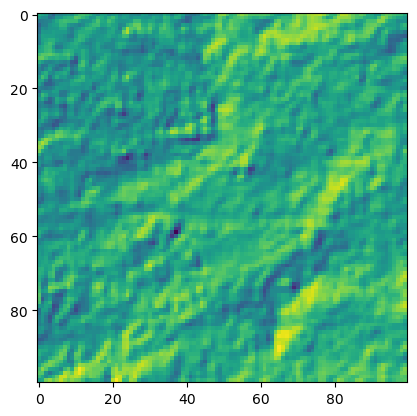

In [11]:
import matplotlib.pyplot as plt
plt.imshow(  image_tensor.permute(1, 2, 0)  )


In [13]:
image_tensor.shape

torch.Size([1, 100, 100])

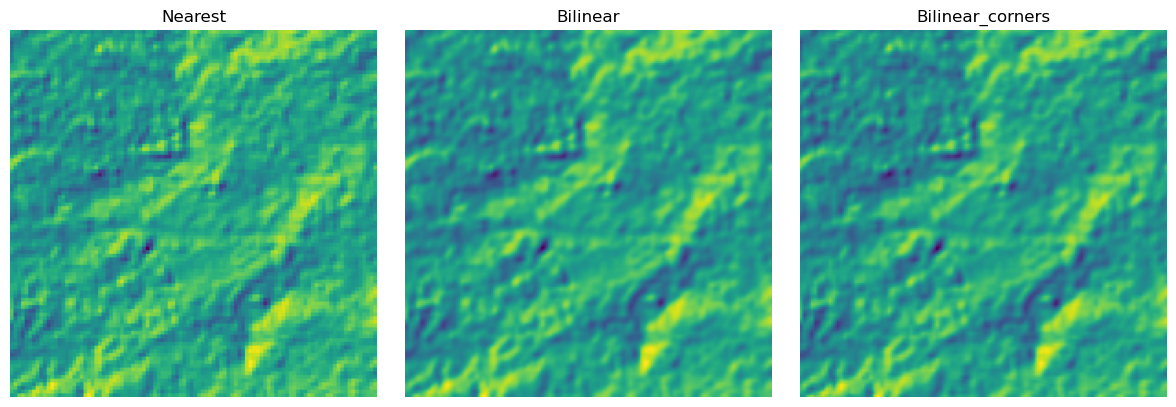

In [20]:
import torch.nn as nn

nearest = nn.Upsample(size=200, mode='nearest')
bilinear = nn.Upsample(size=200, mode='bilinear')
bilinear_corners = nn.Upsample(size=200, mode='bilinear', align_corners = True)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot image1 in the first subplot
axs[0].imshow(nearest(image_tensor.unsqueeze(0)).squeeze(0).permute(1,2,0))
axs[0].set_title('Nearest')
axs[0].axis('off')

# Plot image2 in the second subplot
axs[1].imshow(bilinear(image_tensor.unsqueeze(0)).squeeze(0).permute(1,2,0))
axs[1].set_title('Bilinear')
axs[1].axis('off')

# Plot image3 in the third subplot
axs[2].imshow(bilinear_corners(image_tensor.unsqueeze(0)).squeeze(0).permute(1,2,0))
axs[2].set_title('Bilinear_corners')
axs[2].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


### Figuring out concatenation of RGB and hillshade

In [34]:
# converting hillshade to tensor
image_array = np.array(hs_img.read())
image_tensor = torch.from_numpy(image_array)
hs_image_tensor = image_tensor.float()
bilinear = nn.Upsample(size=200, mode='bilinear')
# Upsampling tensor to match (200,200) from RGB 
# NOTE when using line below elsewhere check that dims right (B,C,H,W)
hs_upsampled_tensor = bilinear(image_tensor.unsqueeze(0)).squeeze(0) 

# converting RGB to tensor
image_array = np.array(RGB_img.read())
image_tensor = torch.from_numpy(image_array)
RGB_image_tensor = image_tensor.float()

combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

"""

NEXT: 
    * concatenate the hs and RGB images to get a (4,200,200 tensor)
    * Maybe need to permute the tensor?
    * do i want to save the tensors as training imgs? or just read both in together in VGG
    * can make it such that Dataloader loops over only _hs or only RGB, then finds the other 
      image, concatenates them and returns the concatenation. 
    * All of the code above should/could be in the imageloader!

    DATALOADER: have rgb and hs in separate folders, iterate over one, match the image in the 
                other, concatenate them and return the concatenation. 

"""


'\n\nNEXT: \n    * concatenate the hs and RGB images to get a (4,200,200 tensor)\n    * (maybe need to permute the tensor? )\n    * do i want to save the tensors as training imgs? or just read both in together in VGG\n    * can make it such that Dataloader loops over only _hs or only RGB, then finds the other \n      image, concatenates them and returns the concatenation. \n    * All of the code above should/could be in the imageloader!\n\n    DATALOADER: have rgb and hs in separate folders, iterate over one, match the image in the \n                other, concatenate them and return the concatenation. \n\n'

### Defining dataset for RGB&hs imgs

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, hs_dir, RGB_dir, labels_df):
        self.RGB_dir = RGB_dir
        self.hs_dir = hs_dir
        self.labels_df = labels_df

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        RGB_img_path = os.path.join(self.RGB_dir, f"{img_name}.tif")
        hs_img_path = os.path.join(self.hs_dir, f"{img_name}_hs.tif")

        with rasterio.open(RGB_img_path) as RGB_src:
            # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(hs_img_path) as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img.read())
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=200, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img.read())
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

        label = self.labels_df.iloc[idx, 0]

        return combined_tensor, label

In [ ]:
image_dir = "/Users/nadja/Documents/UU/Thesis/Data/100m"
labels_file = "/Users/nadja/Documents/UU/Thesis/Data/100m_palsa_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(100)

# Split the dataset into training and validation sets
train_df = labels_df.head(80)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(image_dir, train_df )
val_dataset = ImageDataset(image_dir, val_df )
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [6]:
import torchvision.transforms.functional as TF
import rasterio
import torch
with rasterio.open('/home/nadjaflechner/Palsa_data/generated_datasets/FINAL_200m_dataset/dem/733_52_2525_2015_crop_13.tif') as rgb_src:
    # Read the image data
    rgb_img = rgb_src.read()

rgb_img = torch.Tensor(rgb_img)
new_img = TF.normalize(rgb_img, mean=[0.5], std=[0.2])

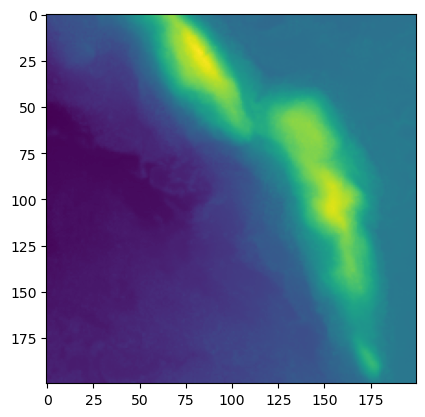

In [10]:
import matplotlib.pyplot as plt

plt.imshow(rgb_img.permute(1,2,0))

In [17]:
import random 
transform = random.choice(['hflip', 'rotate', 'sharpness', 'saturation', 'hue', 'contrast', 'brightness'])

if transform in ['hflip', 'rotate']:
    print('True')

True
